<a href="https://colab.research.google.com/github/vesran/15-puzzle-game/blob/master/Sentiments_segmenter_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers


In [2]:
df_semeval = pd.read_csv('sentiments_semeval.csv', sep=';')

In [3]:
df_yelp = pd.read_csv('sentiments_yelp.csv', sep=';')

In [4]:
df_semeval.head()

,sentence,clean_sentence,label,source
0,But the staff was so horrible to us.,but staff horrible,0,train
1,"The food is uniformly exceptional, with a very...",food uniformly exceptional with very capable k...,1,train
2,Where Gabriela personaly greets you and recomm...,gabriela personal greet recommend eat,1,train
3,"For those that go once and don't enjoy it, all...",those go once not enjoy can say not get,1,train
4,"Not only was the food outstanding, but the lit...",not food outstanding but little perk great,1,train


In [5]:
df_yelp['source'] = 'train'
df_yelp = df_yelp[['sentence', 'clean_sentence', 'label', 'source']].copy()
df_yelp.head()

,sentence,clean_sentence,label,source
0,The food is fresh and so delicious!,food fresh so delicious,1,train
1,Came here on Sunday for dinner and ended up wa...,come here sunday dinner end up wait food hrs n...,0,train
2,I really think alot before even coming to this...,really think lot before even come location,0,train
3,A much needed addition to Winter Park and Orla...,much need addition winter park orlando general,1,train
4,10. international airport,international airport,1,train


In [6]:
df_semeval = df_semeval[df_semeval.source.isin(['train', 'val'])]

In [7]:
df_semeval['origin'] = 'semeval'
df_yelp['origin'] = 'yelp'

In [8]:
df = pd.concat([df_semeval, df_yelp])

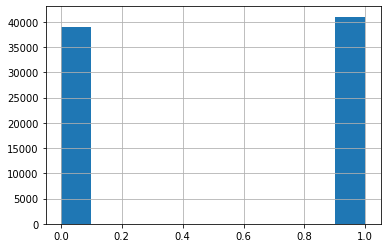

In [9]:
df.label.hist()

In [10]:
df = df[df.clean_sentence.notnull()].copy()

In [11]:
df['num_w'] = df.clean_sentence.apply(lambda x: len(x.split(' ')))

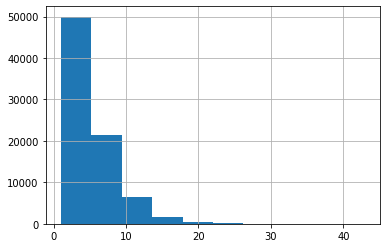

In [12]:
df['num_w'].hist()

In [13]:
df.num_w.describe()

count    79925.000000
mean         5.270078
std          3.319242
min          1.000000
25%          3.000000
50%          4.000000
75%          7.000000
max         43.000000
Name: num_w, dtype: float64

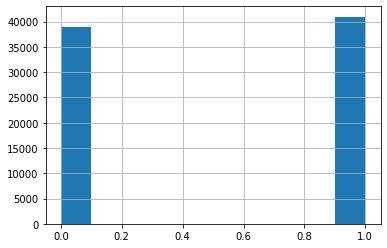

In [14]:
df.label.hist()

In [15]:
sents = df[df.num_w <= 15].copy()

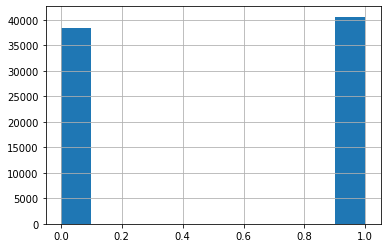

In [16]:
sents.label.hist()

In [17]:
pos = sents.query("label == 1").copy()
neg = sents.query("label == 0").copy()
posneg = pd.concat([pos, neg]).sample(frac=1)

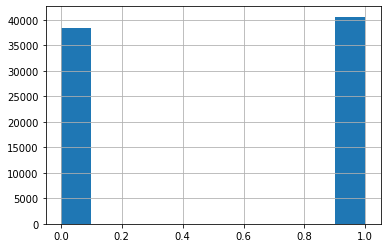

In [18]:
posneg.label.hist()

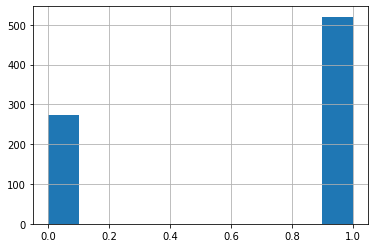

In [19]:
posneg.query("source=='val'").label.hist()

In [20]:
posneg['tokens'] = posneg.clean_sentence.apply(lambda x: x.split(' '))
posneg['tags'] = posneg.apply(lambda x: [x['label']] * len(x['tokens']), axis=1)

In [21]:
train = posneg.query("source == 'train'").copy()
val = posneg.query("source == 'val'").copy()

In [22]:
train.shape

(78114, 8)

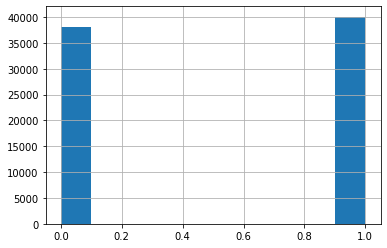

In [23]:
train.label.hist()

In [24]:
val_pos = val.query("label==1").sample(frac=1).head(300).copy()
val_neg = val.query("label==0").copy()

In [25]:
val = pd.concat([val_pos, val_neg]).sample(frac=1)

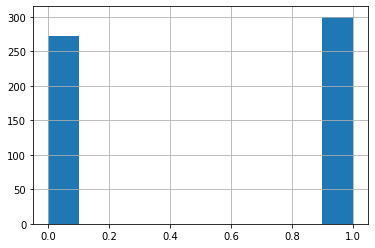

In [26]:
val.label.hist()

In [27]:
max_len = 30

In [28]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
import tensorflow as tf
import numpy as np


def import_GloVe(path):
    embeddings_index = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word.encode()] = coefs
    print(f"Found {len(embeddings_index)} word vectors.")
    return embeddings_index


def prepare_embedding_matrix(embeddings_index, word_index, num_tokens, embedding_dim, binary=False):
    hits, misses = 0, 0
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word if binary else word.encode())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print(f'Hits : {hits} | Misses : {misses}')
    return embedding_matrix


class PretrainedEmbedding(tf.keras.Model):

    def __init__(self, **kwargs):
        super(PretrainedEmbedding, self).__init__()

    def adapt(self, corpus, path, method='glove100'):
        binary = path.split('.')[-1] == 'bin'

        # Build vectorizer
        self.vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=max_len)
        text_ds = tf.data.Dataset.from_tensor_slices(corpus).batch(128)
        self.vectorizer.adapt(text_ds)

        # Word to index
        voc = self.vectorizer.get_vocabulary()
        self.word_index = dict(zip(voc, range(2, len(voc))))

        # Load embeddings
        self.method = method
        embeddings2index = import_GloVe(path)
        emb_dim = 100

        # Create embedding layer
        self.embedding_matrix = prepare_embedding_matrix(embeddings2index, self.word_index, num_tokens=len(voc)+2,
                                                    embedding_dim=100, binary=binary)
        self.embedding_layer = Embedding(len(voc) + 2, emb_dim,
                                         embeddings_initializer=tf.keras.initializers.Constant(self.embedding_matrix),
                                         trainable=False)

    def call(self, string_inputs):
        x = self.vectorizer(string_inputs)
        embs = self.embedding_layer(x)
        return embs


In [29]:
def complete(li, max_len):
    li = li + [li[-1]] * (max_len - len(li))
    li = li[:max_len]
    assert len(li) == max_len
    return li


In [32]:
from tensorflow.keras.utils import Sequence
import numpy as np   
import random

contrasts = ['but', 'however', 'despite', 'while']

class DataGen(Sequence):
    def __init__(self, x, y, batch_size):
        self.y1 = y[::2]
        self.y2 = y[1::2]
        self.x1 = x[::2]  # Tous les éléments d'indice pair
        self.x2 = x[1::2] # Tousl les éléments d'indice impair
        self.batch_size = batch_size

    def __len__(self):
        return int(0.5 * np.ceil((len(self.x1) + len(self.x2)) / float(self.batch_size)))

    def __getitem__(self, idx):
        if idx == 0:
            general_order1 = list(range(len(self.x1)))
            general_order2 = list(range(len(self.x2)))
            random.shuffle(general_order1), random.shuffle(general_order2)
            self.x1 = self.x1[general_order1]
            self.y1 = self.y1[general_order1]
            self.x2 = self.x2[general_order1]
            self.y2 = self.y2[general_order1]

        order1 = list(range(self.batch_size))
        order2 = list(range(self.batch_size))
        random.shuffle(order1), random.shuffle(order2)

        batch_x1 = self.x1[idx * self.batch_size:(idx + 1) * self.batch_size][order1]
        batch_x2 = self.x2[idx * self.batch_size:(idx + 1) * self.batch_size][order2]
        batch_y1 = self.y1[idx * self.batch_size:(idx + 1) * self.batch_size][order1].tolist()
        batch_y2 = self.y2[idx * self.batch_size:(idx + 1) * self.batch_size][order2].tolist()

        # read your data here using the batch lists, batch_x and batch_y
        x = []
        y = []
        for i in range(self.batch_size):
            change_sentiment = batch_y1[i][-1] != batch_y2[i][0]
            if random.random() < 0.5 and change_sentiment:
                contrast = random.choice(contrasts)  # One word
                x_entry = batch_x1[i] + f" {contrast} " + batch_x2[i]
                y_entry = complete(batch_y1[i] + [batch_y2[i][0]] + batch_y2[i], max_len)
            else:
                x_entry = batch_x1[i] + " " + batch_x2[i]
                y_entry = complete(batch_y1[i] + batch_y2[i], max_len)

            # add data
            x.append(x_entry)
            y.append(y_entry)

        return np.array(x), np.array(y)


d = DataGen(train['clean_sentence'].head(10).values, train['tags'].head(10).values, 4)
d[0]

(array(['really enjoy breakfast especially spuds crispy food fresh delicious reasonably price',
        'always deliver wrong order then even answer phone get pizza elsewhere',
        'spoon holder mold your first available appointment two month away not run group campaign',
        'everyone fabulous wonderful update review because ton cool thing with brewery lately'],
       dtype='<U88'),
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]]))

In [33]:
p = PretrainedEmbedding()
p.adapt(train.clean_sentence, './glove.6B.100d.txt')

def get_model():
    inp = tf.keras.Input(shape=(1, ), dtype='string')
    x = inp
    x = p(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001)))(x)
    x = layers.Dropout(0.2)(x)

    out = layers.TimeDistributed(layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(0.001)))(x)

    model = tf.keras.Model(inputs=inp, outputs=out)
    return model


model = get_model()
model.summary()

Found 400000 word vectors.
Hits : 12775 | Misses : 654
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
pretrained_embedding (Pretra (None, 30, 100)           1343300   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 256)           234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 256)           394240    
_________________________________________________________________
dropout (Dropout)            (None, 30, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 256)           394240    
_________________________________________________________________
bidire

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss="binary_crossentropy",
              metrics=["acc"])

batch_size = 128
datagen = DataGen(train['clean_sentence'].values, train['tags'].values, batch_size)
val_datagen = DataGen(val['clean_sentence'].values, val['tags'].values, batch_size)

hist = model.fit(datagen, epochs=20, validation_data=val_datagen,
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/20
305/305 [==============================] - 146s 443ms/step - loss: 0.6673 - acc: 0.6721 - val_loss: 0.5223 - val_acc: 0.7603
Epoch 2/20
305/305 [==============================] - 134s 440ms/step - loss: 0.4832 - acc: 0.7930 - val_loss: 0.4816 - val_acc: 0.7919
Epoch 3/20
305/305 [==============================] - 132s 432ms/step - loss: 0.4287 - acc: 0.8271 - val_loss: 0.4845 - val_acc: 0.8126
Epoch 4/20
305/305 [==============================] - 131s 431ms/step - loss: 0.3878 - acc: 0.8479 - val_loss: 0.4136 - val_acc: 0.8350
Epoch 5/20
305/305 [==============================] - 131s 430ms/step - loss: 0.3711 - acc: 0.8561 - val_loss: 0.3933 - val_acc: 0.8435
Epoch 6/20
305/305 [==============================] - 132s 434ms/step - loss: 0.3562 - acc: 0.8634 - val_loss: 0.4064 - val_acc: 0.8329
Epoch 7/20
305/305 [==============================] - 134s 439ms/step - loss: 0.3434 - acc: 0.8716 - val_loss: 0.3849 - val_acc: 0.8480
Epoch 8/20
305/305 [============================

In [55]:
model_name = 'anaseq_008'
model.save(model_name)

import shutil
shutil.make_archive(model_name, 'zip', model_name)

INFO:tensorflow:Assets written to: anaseq_008/assets


'/content/anaseq_008.zip'

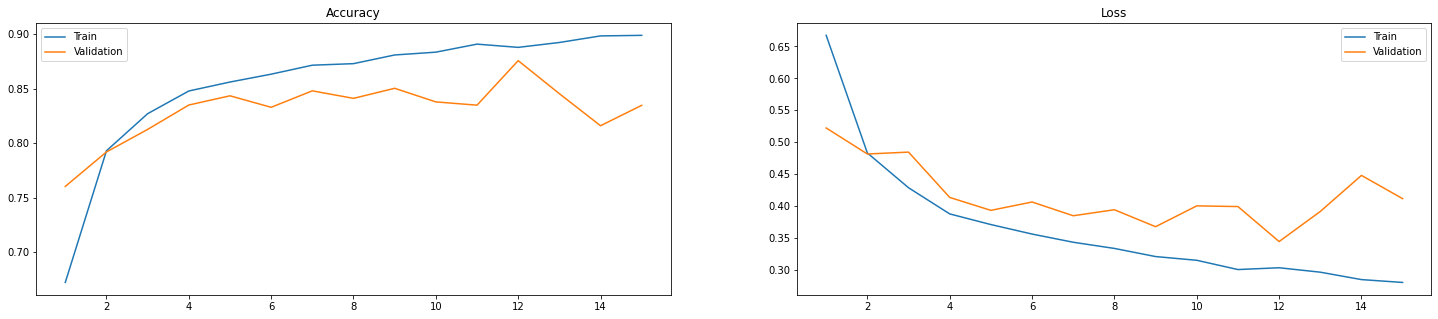

In [35]:
def plot_hist(hist):
    h = hist.history
    _, axs = plt.subplots(1, 2, figsize=(25, 5))
    axs = np.ravel(axs)
    ax = axs[0]
    ax.plot(range(1, len(h['acc'])+1), h['acc'], label='Train')
    ax.plot(range(1, len(h['val_acc'])+1), h['val_acc'], label='Validation')
    ax.set_title('Accuracy')
    ax.legend()
    ax = axs[1]
    ax.plot(range(1, len(h['loss'])+1), h['loss'], label='Train')
    ax.plot(range(1, len(h['val_loss'])+1), h['val_loss'], label='Validation')
    ax.set_title('Loss')
    ax.legend();

plot_hist(hist)

In [36]:
testset = pd.read_csv('sentiments_testset.csv', sep=';')

In [39]:
def debug_infer(df, i, model):
    print(df.sentence.iloc[i])
    text = df.clean_sentence.iloc[i]
    pred = model.predict(np.array([text]).reshape(-1, 1)).flatten()
    print(text)
    tokens = df.clean_sentence.iloc[i].split(' ')
    for k, (p, w) in enumerate(zip(pred, tokens)):
        if "tags" in df.columns:
            print(df.tags.iloc[i][k], p, w)
        else:
            print(p, w)

debug_infer(testset, 1, model)

I have to say they have one of the fastest delivery times in the city.
say one fast delivery time city
0.68062377 say
0.8187174 one
0.8970187 fast
0.92714393 delivery
0.9360809 time
0.9360083 city


In [40]:
sample = val_datagen[0]

In [41]:
model.evaluate(sample[0], sample[1])

4/4 [==============================] - 1s 61ms/step - loss: 0.3574 - acc: 0.8555


[0.3573765754699707, 0.85546875]

In [42]:
probas = model.predict(sample[0])
preds = np.around(probas)
pred = preds.reshape(1, batch_size, -1)
gt = sample[1]

In [43]:
errors_matrix = (gt != pred)
error_values = errors_matrix.sum(axis=2)

In [44]:
error_values

array([[ 8,  0,  0, 15,  1,  0,  2,  0, 28,  0,  0,  0,  0, 21,  0,  2,
         0,  0,  2,  0,  0,  0,  0,  0,  0,  2,  6, 26,  0,  0,  2, 23,
         8, 25,  1,  0,  0,  0,  0, 26,  6, 22,  0,  0,  0,  0,  0, 30,
        27,  0,  0,  0,  1,  7,  0,  0,  0,  1,  7,  0,  0,  0,  1, 25,
         0, 25,  7,  2,  3,  1,  0,  2,  2,  0,  3,  0,  0,  0,  0, 15,
         1,  0,  1,  5,  0,  0,  0,  0,  4,  0,  7,  0,  0,  1,  0,  0,
         1,  0,  0, 22,  4, 20,  0,  2,  0,  0, 21, 18,  0,  0,  6, 10,
         9,  0, 16,  5,  7,  0,  0,  1,  0,  0,  0,  8,  0,  0,  1,  0]])

In [49]:
errors_mask = (error_values > 10).flatten()
errors = sample[0][errors_mask]
print(errors.shape)

(18,)


In [50]:
errors

array(['wide variety fish even list ocean come from atlantic or pacific table not understand sense humour but refreshing server who personality professionalism respect privacy your dinner',
       'amazing favourite us now appetizer',
       're say enough their delicious gourmet pizza good place leisure sunday breakfast amidst yacht then take stroll nearby farmer market',
       'put out name down although open table tell minute wait but bison quite excellent however',
       'after sit with empty glass minute leave appreciate their delivery too',
       'upstairs great place hang out but maybe good one night once blue moon when chef decide use fish half way decent',
       'not sure go back food simply unforgettable',
       'naan good really enjoy martha not too tomatoes hassle',
       'not too fine think feel uncomfortable dress drink superb feel like third world country when walk door',
       'entree very good while want go see worth sadly curiosity get good pay dearly',
       

In [52]:
def single_pred(text, model, labels=None):
    print(text)
    pred = model.predict(np.array([text]).reshape(-1, 1)).flatten()
    tokens = text.split(' ')
    for k, (p, w) in enumerate(zip(pred, tokens)):
        if labels:
            print(labels[k], p, w)
        else:
            print(p, w)


text = 'not place once believe expensive restaurant can disrespectful client'
single_pred(text, model)

not place once believe expensive restaurant can disrespectful client
0.21675573 not
0.22164005 place
0.2348368 once
0.25637925 believe
0.2876046 expensive
0.3295345 restaurant
0.38025445 can
0.43133685 disrespectful
0.47352135 client


In [53]:
p.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
pretrained_embedding (Pretra (None, 30, 100)           1343300   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 256)           234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 256)           394240    
_________________________________________________________________
dropout (Dropout)            (None, 30, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 256)           394240    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 30, 256)           394240

In [54]:
# Finetuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003),
              loss="binary_crossentropy",
              metrics=["acc"])

batch_size = 128
datagen = DataGen(train['clean_sentence'].values, train['tags'].values, batch_size)
val_datagen = DataGen(val['clean_sentence'].values, val['tags'].values, batch_size)

hist2 = model.fit(datagen, epochs=15, validation_data=val_datagen,
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/15
305/305 [==============================] - 146s 456ms/step - loss: 0.2709 - acc: 0.9038 - val_loss: 0.3684 - val_acc: 0.8704
Epoch 2/15
305/305 [==============================] - 138s 451ms/step - loss: 0.2593 - acc: 0.9092 - val_loss: 0.3538 - val_acc: 0.8677
Epoch 3/15
305/305 [==============================] - 137s 449ms/step - loss: 0.2567 - acc: 0.9108 - val_loss: 0.3897 - val_acc: 0.8527
Epoch 4/15
305/305 [==============================] - 137s 450ms/step - loss: 0.2538 - acc: 0.9112 - val_loss: 0.3557 - val_acc: 0.8723
Epoch 5/15
305/305 [==============================] - 137s 449ms/step - loss: 0.2471 - acc: 0.9151 - val_loss: 0.3396 - val_acc: 0.8849
Epoch 6/15
305/305 [==============================] - 137s 450ms/step - loss: 0.2435 - acc: 0.9163 - val_loss: 0.3089 - val_acc: 0.8913
Epoch 7/15
305/305 [==============================] - 139s 457ms/step - loss: 0.2447 - acc: 0.9168 - val_loss: 0.3920 - val_acc: 0.8546
Epoch 8/15
305/305 [============================

In [45]:
model.save(model_name)

import shutil
shutil.make_archive(model_name, 'zip', model_name)

INFO:tensorflow:Assets written to: anaseq_007/assets


'/content/anaseq_007.zip'

In [56]:
hist.history['acc'] += hist2.history['acc']
hist.history['loss'] += hist2.history['loss']
hist.history['val_acc'] += hist2.history['val_acc']
hist.history['val_loss'] += hist2.history['val_loss']

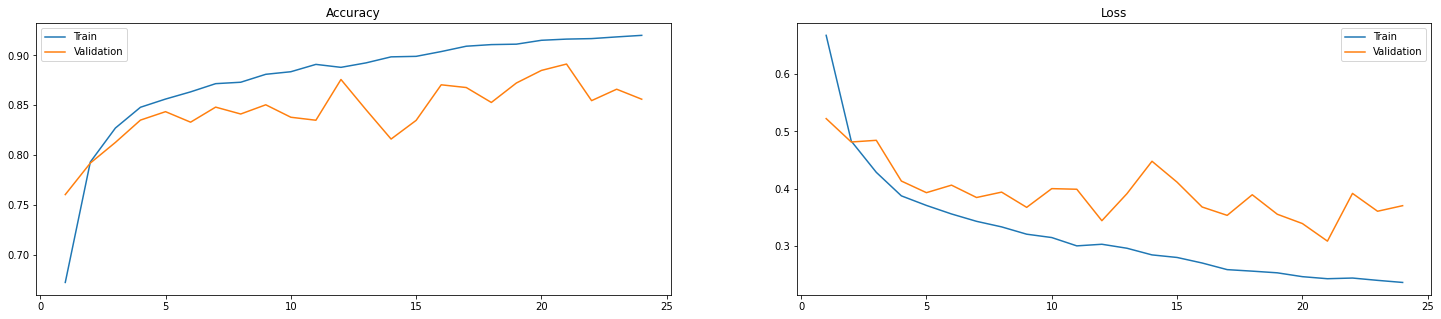

In [57]:
plot_hist(hist)

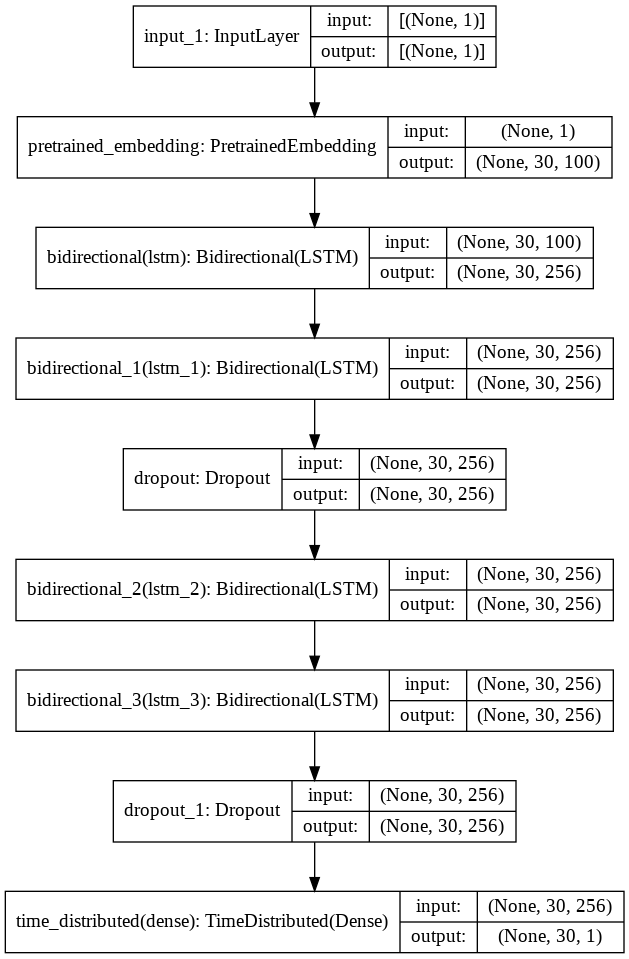

In [58]:
tf.keras.utils.plot_model(
    model, show_shapes=True, show_dtype=False,
    show_layer_names=True, expand_nested=False, dpi=96
)